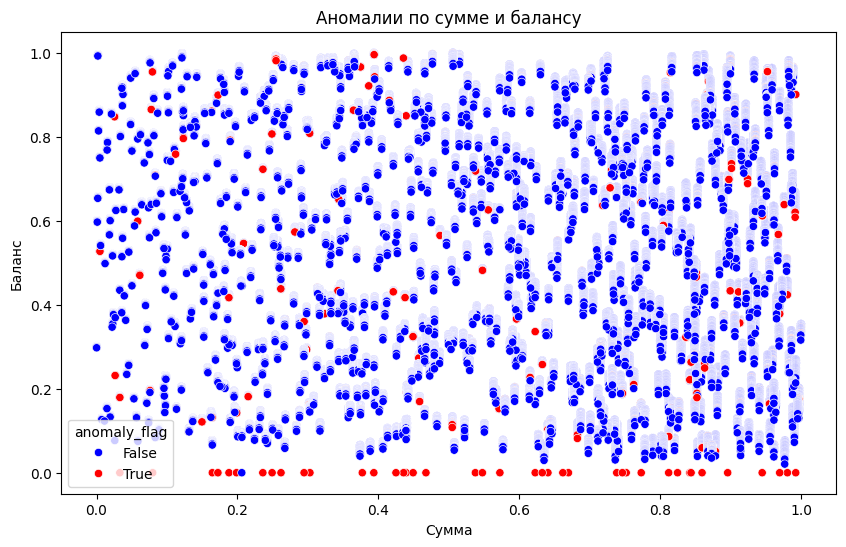

<ipython-input-4-23ef45ff85af>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data[data['anomaly_flag'] == True], x='hour', palette='Reds')


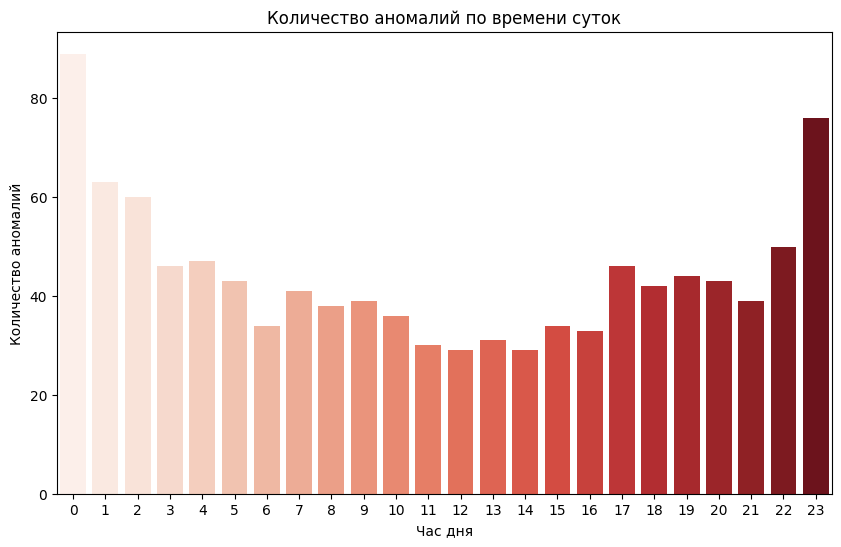

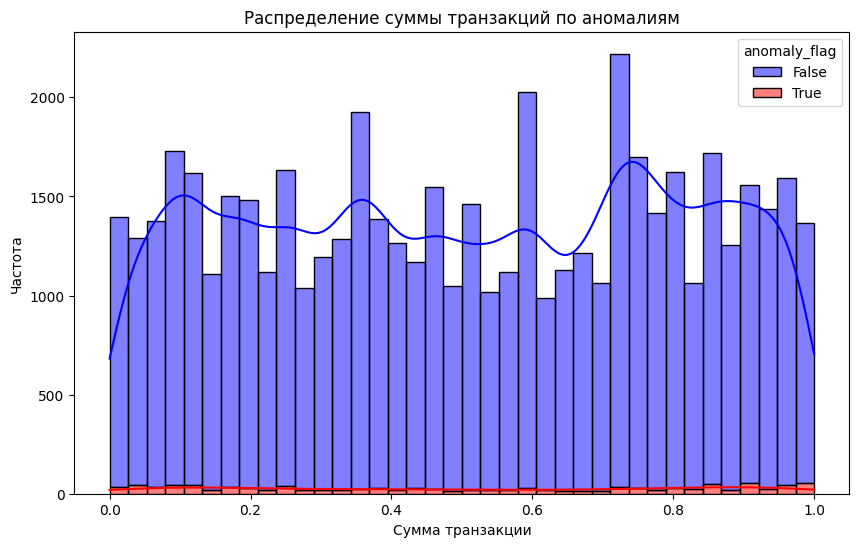

<ipython-input-4-23ef45ff85af>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data[data['anomaly_flag'] == True], x='day_of_week', palette='Reds')


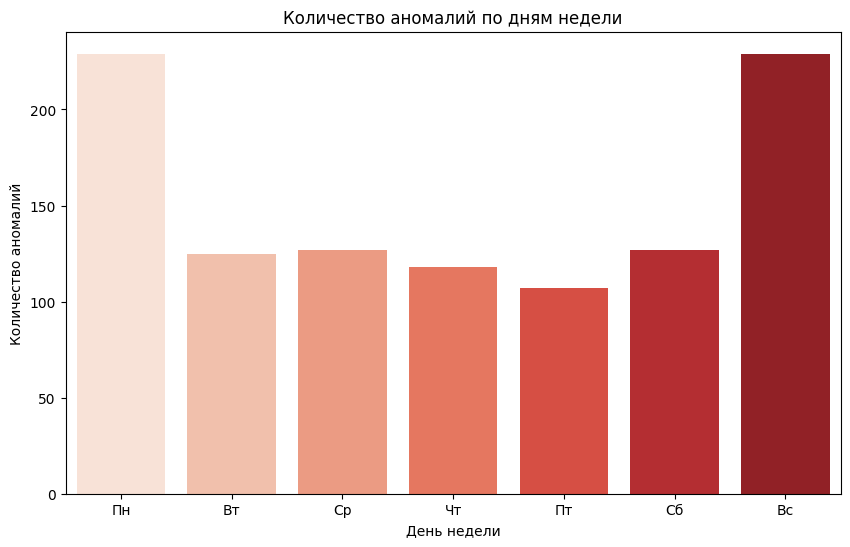

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import files

# Загрузка данных
data = pd.read_csv('dataset.csv')

# Удаление пропусков
data = data.dropna()

# Преобразование категориальных данных
le = LabelEncoder()
for col in ['device_type', 'tran_code', 'card_type', 'oper_type', 'card_status']:
    data[col] = le.fit_transform(data[col].astype(str))

# Создание временных признаков
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
if data['datetime'].isnull().any():
    raise ValueError("Некорректные значения в столбце 'datetime' после преобразования.")
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek

# Дополнительные признаки для аномалий
data['is_night'] = data['hour'].between(0, 6)  # Ночь с 0 до 6 часов

# Аномалии по балансу
balance_mean = data['balance'].mean()
balance_std = data['balance'].std()
data['balance_anomaly'] = (data['balance'] > balance_mean + 3 * balance_std) | (data['balance'] < balance_mean - 3 * balance_std)

# Аномалии по сумме
sum_mean = data['sum'].mean()
sum_std = data['sum'].std()
data['sum_anomaly'] = (data['sum'] > sum_mean + 3 * sum_std) | (data['sum'] < sum_mean - 3 * sum_std)

# Нормализация числовых данных
scaler = MinMaxScaler()
data[['sum', 'balance', 'pin_inc_count']] = scaler.fit_transform(data[['sum', 'balance', 'pin_inc_count']])

# Инициализация модели Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)

# Обучение модели на выбранных признаках
features = ['sum', 'balance', 'pin_inc_count', 'device_type', 'hour', 'day_of_week', 'tran_code', 'oper_type', 'card_status']
model.fit(data[features])

# Предсказание аномалий (-1 = аномалия, 1 = нормальная транзакция)
data['anomaly'] = model.predict(data[features])

# Преобразование предсказаний аномалии в True (анализ) и False (нормально)
data['anomaly_flag'] = data['anomaly'] == -1

# Визуализация аномалий

# 1. Scatter Plot: аномалии по сумме и балансу
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='sum', y='balance', hue='anomaly_flag', palette={True: 'red', False: 'blue'})
plt.title("Аномалии по сумме и балансу")
plt.xlabel("Сумма")
plt.ylabel("Баланс")
plt.show()

# 2. Count Plot: количество аномалий по времени суток
plt.figure(figsize=(10, 6))
sns.countplot(data=data[data['anomaly_flag'] == True], x='hour', palette='Reds')
plt.title("Количество аномалий по времени суток")
plt.xlabel("Час дня")
plt.ylabel("Количество аномалий")
plt.show()

# 3. Histogram: распределение суммы транзакций для нормальных и аномальных данных
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='sum', hue='anomaly_flag', multiple="stack", kde=True, palette={True: 'red', False: 'blue'})
plt.title("Распределение суммы транзакций по аномалиям")
plt.xlabel("Сумма транзакции")
plt.ylabel("Частота")
plt.show()

# 4. Визуализация активности по дням недели
plt.figure(figsize=(10, 6))
sns.countplot(data=data[data['anomaly_flag'] == True], x='day_of_week', palette='Reds')
plt.title("Количество аномалий по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество аномалий")
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])  # Переименовываем метки
plt.show()

# Сохранение данных с аномалиями в CSV файл
output_path = '/content/preds.csv'
data[['anomaly_flag']].to_csv(output_path, index=False)

# Скачивание файла на локальное устройство
files.download(output_path)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Лучшие параметры: {'contamination': 0.01, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 100}


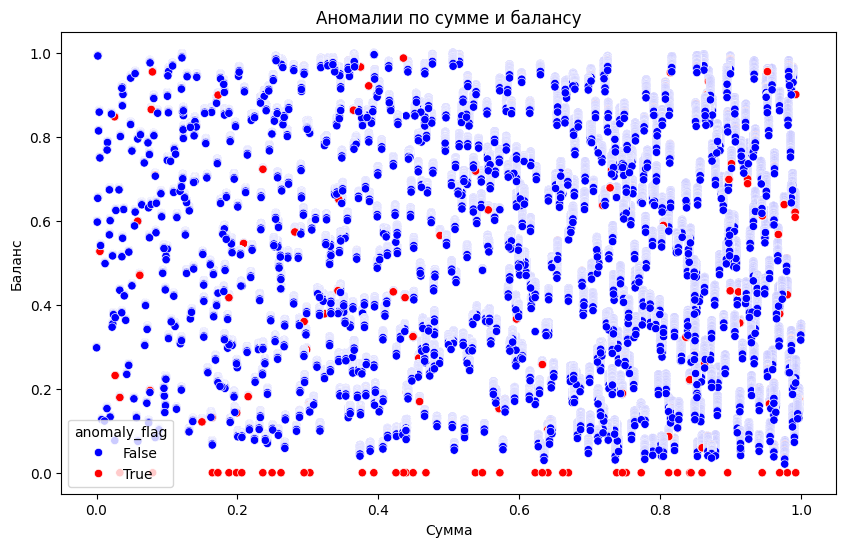

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Загрузка данных
data_path = '/content/dataset.csv'
data = pd.read_csv(data_path)

# Удаление пропусков
data = data.dropna()

# Преобразование категориальных данных
le = LabelEncoder()
for col in ['device_type', 'tran_code', 'card_type', 'oper_type', 'card_status']:
    data[col] = le.fit_transform(data[col].astype(str))

# Создание временных признаков
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek

# Нормализация числовых данных
scaler = MinMaxScaler()
data[['sum', 'balance', 'pin_inc_count']] = scaler.fit_transform(data[['sum', 'balance', 'pin_inc_count']])

# Признаки для модели
features = ['sum', 'balance', 'pin_inc_count', 'device_type', 'hour',
            'day_of_week', 'tran_code', 'oper_type', 'card_status']

X_train, X_test = train_test_split(data[features], test_size=0.2, random_state=42)

# **Кросс-валидация для Isolation Forest**
param_grid = {
    'n_estimators': [100, 150, 200],   # Количество деревьев
    'max_samples': [0.8, 1.0],        # Доля используемых данных
    'max_features': [0.8, 1.0],       # Доля признаков
    'contamination': [0.01, 0.02, 0.05]  # Доля аномалий
}

# Создание модели
base_model = IsolationForest(random_state=42, bootstrap=True)

# Используем GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='f1',  # Метрика для оценки (можно заменить на вашу)
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Подбор параметров
grid_search.fit(X_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)

# Используем лучшую модель
best_model = grid_search.best_estimator_

# Предсказания
data['anomaly'] = best_model.predict(data[features])
data['anomaly_flag'] = data['anomaly'] == -1

# Визуализация
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='sum', y='balance', hue='anomaly_flag', palette={True: 'red', False: 'blue'})
plt.title("Аномалии по сумме и балансу")
plt.xlabel("Сумма")
plt.ylabel("Баланс")
plt.show()

# Сохранение
output_path = '/content/preds_with_cv.csv'
data[['anomaly_flag']].to_csv(output_path, index=False)

files.download(output_path)


0.5739077497386577

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Лучшие параметры: {'contamination': 0.01, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 100}
F1-Score (Train): 1.0
F1-Score (Test): 1.0
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10496
           1       1.00      1.00      1.00       120

    accuracy                           1.00     10616
   macro avg       1.00      1.00      1.00     10616
weighted avg       1.00      1.00      1.00     10616



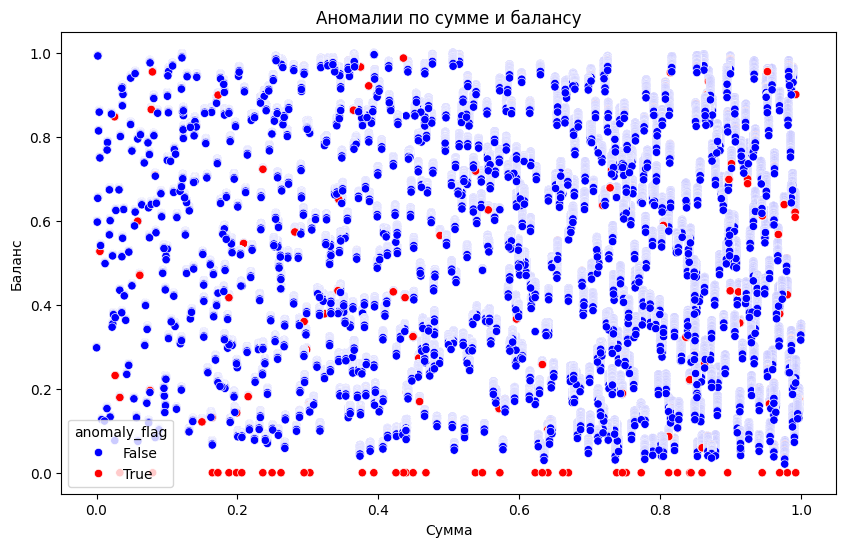

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Загрузка данных
data_path = '/content/dataset.csv'  # Укажите путь к вашему файлу
data = pd.read_csv(data_path)

# Удаление пропусков
data = data.dropna()

# Преобразование категориальных данных
le = LabelEncoder()
for col in ['device_type', 'tran_code', 'card_type', 'oper_type', 'card_status']:
    data[col] = le.fit_transform(data[col].astype(str))

# Создание временных признаков
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek

# Нормализация числовых данных
scaler = MinMaxScaler()
data[['sum', 'balance', 'pin_inc_count']] = scaler.fit_transform(data[['sum', 'balance', 'pin_inc_count']])

# Признаки для модели
features = ['sum', 'balance', 'pin_inc_count', 'device_type', 'hour',
            'day_of_week', 'tran_code', 'oper_type', 'card_status']

X = data[features]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# **Кросс-валидация для Isolation Forest**
param_grid = {
    'n_estimators': [100, 150, 200],   # Количество деревьев
    'max_samples': [0.8, 1.0],        # Доля используемых данных
    'max_features': [0.8, 1.0],       # Доля признаков
    'contamination': [0.01, 0.02, 0.05]  # Доля аномалий
}

# Создание модели
base_model = IsolationForest(random_state=42, bootstrap=True)

# Используем GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='f1',  # Метрика для оценки
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Подбор параметров
grid_search.fit(X_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)

# Используем лучшую модель
best_model = grid_search.best_estimator_

# Получаем предсказания для обучающих данных
y_train_pred = best_model.predict(X_train)
y_train_pred = (y_train_pred == -1).astype(int)  # Аномалии как 1, нормальные как 0

# Получаем предсказания для тестовых данных
y_test_pred = best_model.predict(X_test)
y_test_pred = (y_test_pred == -1).astype(int)  # Аномалии как 1, нормальные как 0

# Печать метрик модели на основе предсказаний
print(f"F1-Score (Train): {f1_score(y_train_pred, y_train_pred)}")  # Используем F1-Score
print(f"F1-Score (Test): {f1_score(y_test_pred, y_test_pred)}")  # Для теста
print(f"Classification Report (Test):\n{classification_report(y_test_pred, y_test_pred)}")

# Визуализация аномалий
data['anomaly_flag'] = best_model.predict(X[features]) == -1  # Предсказания для всех данных
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='sum', y='balance', hue='anomaly_flag', palette={True: 'red', False: 'blue'})
plt.title("Аномалии по сумме и балансу")
plt.xlabel("Сумма")
plt.ylabel("Баланс")
plt.show()

# Сохранение результатов в CSV файл
output_path = '/content/preds_with_feature_selection.csv'
data[['anomaly_flag']].to_csv(output_path, index=False)

# Скачивание файла
files.download(output_path)


0.9623134971506135

F1-Score (Train): 0.0
F1-Score (Test): 0.0
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10611
           1       0.00      0.00      0.00         5

    accuracy                           1.00     10616
   macro avg       0.50      0.50      0.50     10616
weighted avg       1.00      1.00      1.00     10616



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


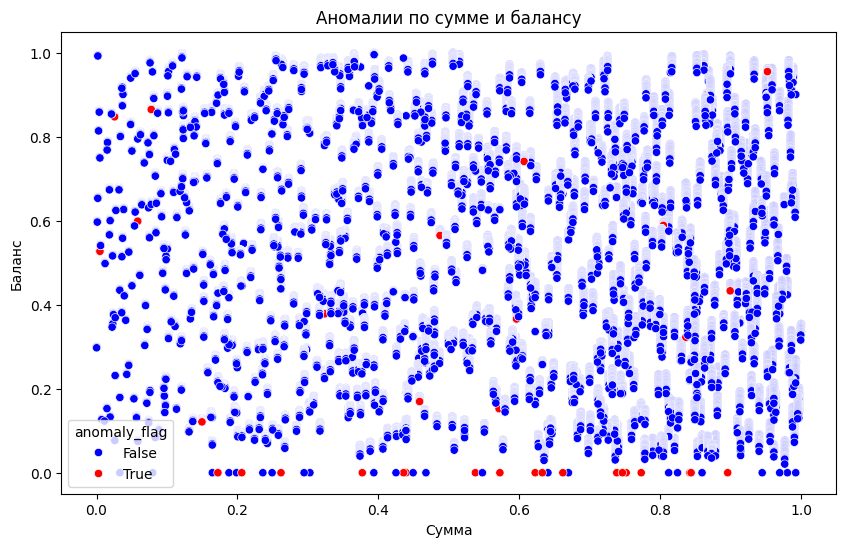

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Загрузка данных
data_path = '/content/dataset.csv'
data = pd.read_csv(data_path)

# Удаление пропусков
data = data.dropna()

# Преобразование категориальных данных
le = LabelEncoder()
for col in ['device_type', 'tran_code', 'card_type', 'oper_type', 'card_status']:
    data[col] = le.fit_transform(data[col].astype(str))

# Создание временных признаков
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek

# Нормализация числовых данных
scaler = MinMaxScaler()
data[['sum', 'balance', 'pin_inc_count']] = scaler.fit_transform(data[['sum', 'balance', 'pin_inc_count']])

# Признаки для модели
features = ['sum', 'balance', 'pin_inc_count', 'device_type', 'hour',
            'day_of_week', 'tran_code', 'oper_type', 'card_status']

X = data[features]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# 1. **Использование K-Nearest Neighbors для аномалий**
knn = NearestNeighbors(n_neighbors=20)
knn.fit(X_train)

# Для каждой точки вычисляем расстояния до ближайших соседей
distances, _ = knn.kneighbors(X_train)

# Расстояния до ближайших соседей могут помочь нам выделить аномалии
threshold = 0.8 * distances.max()  # Задаем порог для аномалий
y_train_pred = (distances[:, -1] > threshold).astype(int)

# Тестируем на тестовой выборке
distances_test, _ = knn.kneighbors(X_test)
y_test_pred = (distances_test[:, -1] > threshold).astype(int)

# Оценка метрик
print(f"F1-Score (Train): {f1_score(y_train_pred, [0] * len(y_train_pred))}")
print(f"F1-Score (Test): {f1_score(y_test_pred, [0] * len(y_test_pred))}")
print(f"Classification Report (Test):\n{classification_report(y_test_pred, [0] * len(y_test_pred))}")

# Визуализация
data['anomaly_flag'] = knn.kneighbors(X[features])[0][:, -1] > threshold  # Метки аномалий для всех данных
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='sum', y='balance', hue='anomaly_flag', palette={True: 'red', False: 'blue'})
plt.title("Аномалии по сумме и балансу")
plt.xlabel("Сумма")
plt.ylabel("Баланс")
plt.show()

# Сохранение результатов в CSV файл
output_path = '/content/preds_with_knn.csv'
data[['anomaly_flag']].to_csv(output_path, index=False)

# Скачивание файла
files.download(output_path)


0.9631164024156502

Fitting 3 folds for each of 135 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Лучшие параметры KNN: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}
F1-Score (Test): 0.0
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10611
           1       0.00      0.00      0.00         5

    accuracy                           1.00     10616
   macro avg       0.50      0.50      0.50     10616
weighted avg       1.00      1.00      1.00     10616



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


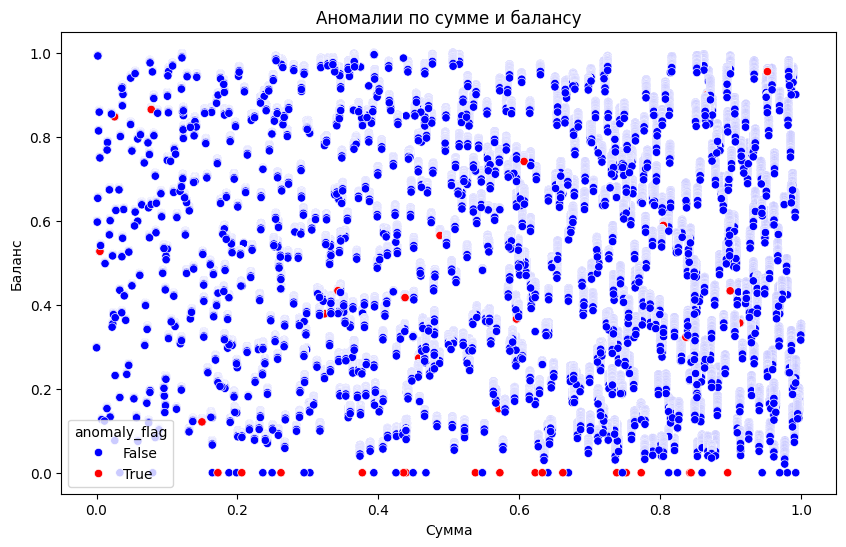

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Параметры для оптимизации
param_grid = {
    'n_neighbors': [10, 15, 20, 25, 30],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'leaf_size': [20, 30, 40]
}

# Создание модели
knn = NearestNeighbors()

# Подбор гиперпараметров через GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)

# Обучение на тренировочных данных
grid_search.fit(X_train)

# Лучшие параметры
print("Лучшие параметры KNN:", grid_search.best_params_)

# Получаем лучшую модель
best_knn = grid_search.best_estimator_

# Получаем аномалии с лучшими параметрами
distances, _ = best_knn.kneighbors(X_train)
threshold = 0.8 * distances.max()  # Порог для аномалии

# Предсказания
distances_test, _ = best_knn.kneighbors(X_test)
y_test_pred = (distances_test[:, -1] > threshold).astype(int)

# Оценка метрик
print(f"F1-Score (Test): {f1_score(y_test_pred, [0] * len(y_test_pred))}")
print(f"Classification Report (Test):\n{classification_report(y_test_pred, [0] * len(y_test_pred))}")

# Визуализация
data['anomaly_flag'] = best_knn.kneighbors(X[features])[0][:, -1] > threshold  # Метки аномалий для всех данных
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='sum', y='balance', hue='anomaly_flag', palette={True: 'red', False: 'blue'})
plt.title("Аномалии по сумме и балансу")
plt.xlabel("Сумма")
plt.ylabel("Баланс")
plt.show()

# Сохранение результатов в CSV файл
output_path = '/content/preds_with_optimal_knn.csv'
data[['anomaly_flag']].to_csv(output_path, index=False)

# Скачивание файла
files.download(output_path)
